In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 

In [2]:
import sys
import xarray as xr
import numpy as np
import Plotter
from Plotter import Plotter
import time
from preprocessing_utils import *
import pandas as pd
import pyxpcm
from pyxpcm.models import pcm
import warnings
import glob
import dask
import dask_ml
from dask_ml.cluster import KMeans
from dask_ml.model_selection import train_test_split
warnings.filterwarnings('ignore')
from dask.distributed import Client

In [3]:
# client.shutdown()

In [4]:
# client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB')
# client


In [5]:
%load_ext memory_profiler
%load_ext line_profiler

In [6]:
def predict(x, m, var_name_ds, k, var_predict):
    classif = m.predict(x[var_predict])
    x = x.assign(variables={"labels": ('sample_dim', classif)})
    q = [0.05, 0.5, 0.95]
    x = compute_quantile(x, var_name_ds, k, q)
    x = x.assign_coords(coords={'k': range(k)})
    x = x.unstack('sample_dim')
    return x

In [7]:
def generate_plots(ds, var_name_ds, k, algorithm):
    """
    Generates and saves the following plots:
    - vertical structure: vertical structure of each classes. It draws the mean profile and the 0.05 and 0.95 quantiles
    - vertical structure comp: vertical structure graph but Quantiles are being plotted together to highlight
    differences between classes.
    - Spacial distribution: plot the PCM labels in a map to analyse the spatial coherence of classes.
    - Robustness: spacial distribution of a scaled probability of a profile to belong to a class.
    - Pie chart: pie chart showing the percentage of profiles belonging to each class and the number of
    classified profiles.
    - Temporal distribution by month: The bar plots represents the percentage of profiles in each class by month.
    - Temporal distribution by season: The bar plots represents the percentage of profiles in each class by season.
    Parameters
    ----------
    ds : Xarray dataset containing the predictions
    var_name_ds : name of the variable in the dataset

    Returns
    -------
    saves all the plots as png
    """
    try:
        x_label = ds[var_name_ds].attrs['long_name'] + " in " + ds[var_name_ds].attrs['unit_long']
    except KeyError:
        x_label = var_name_ds

    # create a pyXpcm model to use the Plotter class
    var_name_mdl = var_name_ds
    z_dim = 'depth'
    z = ds[z_dim]
    pcm_features = {var_name_mdl: z}
    m = pcm(K=k, features=pcm_features)
    ds = ds.rename({'labels': 'PCM_LABELS'})
    ds = ds.sortby('latitude').sortby('longitude')
    P = Plotter(ds, m, coords_dict={'latitude': 'latitude', 'longitude': 'longitude', 'time': 'time', 'depth': 'depth'})

    # plot profiles by class
    P.vertical_structure(q_variable=var_name_ds + '_Q', sharey=True, xlabel=x_label)
#     P.save_BlueCloud(f'./GMM_scaling_out/vertical_struc{algorithm}.png')
    # plot profiles by quantile
    P.vertical_structure_comp(q_variable=var_name_ds + '_Q', plot_q='all', xlabel=x_label)
#     P.save_BlueCloud(f'./GMM_scaling_out/vertical_struc_comp{algorithm}.png')
    # spacial distribution
    P.spatial_distribution(time_slice='most_freq_label')
#     P.save_BlueCloud(f'./GMM_scaling_out/spatial_distr_freq{algorithm}.png')
    # robustness
    # P.plot_robustness(time_slice=first_date)
    # P.save_BlueCloud('robustness.png')
    # pie chart of the classes distribution
    P.pie_classes()
#     P.save_BlueCloud(f'./GMM_scaling_out/pie_chart{algorithm}.png')
    # temporal distribution (monthly)
    try:
        P.temporal_distribution(time_bins='month')
#         P.save_BlueCloud('temporal_distr_months.png')
    except (ValueError, AssertionError) as e:
#         save_empty_plot('temporal_distr_months')
        print('plot monthly temporal distribution is not available, the following error occurred:')
        print(e, file=sys.stderr)
    # temporal distribution (seasonally)
    try:
        P.temporal_distribution(time_bins='season')
#         P.save_BlueCloud('temporal_distr_season.png')
    except (ValueError, AssertionError) as e:
#         save_empty_plot('temporal_distr_season')
        print('plot seasonal temporal distribution is not available, the following error occurred:')
        print(e, file=sys.stderr)

# Execution of the code

## parameters

In [27]:
var_name_ds = "thetao"
# var_name_ds = "TEMP"
var_name_mdl = "temperature"
k = 8
# dir_path = '/home/ref-coriolis-public/copernicus/INSITU_GLO_TS_OA_REP_OBSERVATIONS_013_002_b/CORIOLIS-GLOBAL-CORA-OBS_FULL_TIME_SERIE/field/'
# file_list = glob.glob(f"{dir_path}2019/*TEMP.nc")
# file_list+=glob.glob(f"{dir_path}2018/*TEMP.nc")
dir_path = "../datasets/"
file_list = glob.glob(f"{dir_path}global-reanalysis-phy-001-030-monthly_big.nc")
print(len(file_list))
spacial_domain = {"lon":[-5, 42],
                 "lat": [30, 46],
                 "depth": 800}
spacial_domain

1


{'lon': [-5, 42], 'lat': [30, 46], 'depth': 800}

## Load and preprocessing
see in file preprocessing utils for details

In [28]:
# with dask.config.set(scheduler='single-threaded'):
with dask.config.set(scheduler='threads'):
    %lprun -f preprocessing_allin x = preprocessing_allin(path=file_list, scaling=True, multiple=True, backend='dask', var_name=var_name_ds, n_comp_pca=15, spacial_domain=spacial_domain)

size full DS: 1.303983673453331 Go
size after selection of variable: 1.285902887582779 Go


Timer unit: 1e-06 s

Total time: 79.4743 s
File: /export/home/lbachelo/Documents/BlueCloud/speed_test/preprocessing_utils.py
Function: preprocessing_allin at line 90

Line #      Hits         Time  Per Hit   % Time  Line Contents
    90                                           def preprocessing_allin(path, scaling, backend, multiple, var_name, n_comp_pca, spacial_domain='glob'):
    91         1      15769.0  15769.0      0.0      ds = read_dataset(path, multiple, backend)
    92         1     239436.0 239436.0      0.3      ds = select_var(ds, var_name, multiple, backend, spacial_domain)
    93         1   21633549.0 21633549.0     27.2      x = filter_profiles(ds)
    94                                               #     interpolation and drop all nan not used since they are all filtered in "filter_profiles"
    95                                               #     x = interpolation(x, 'depth')
    96                                               #     x = drop_all_NaN(x)
    97  

In [29]:
var_train = var_name_ds + "_scaled_reduced"
# train_size = len(x[var_name_ds])-1
train_size = 1000
x_train, x_test = train_test_split(x[var_train], test_size=1, train_size=train_size, random_state=42)
print(f"x_train: {x_train.shape}")
print(f"x_test: {x_test.shape}")

x_train: (1000, 15)
x_test: (1, 15)


In [30]:
x_train

<xarray.DataArray 'thetao_scaled_reduced' (sample_dim: 1000, feature_reduced: 15)>
dask.array<getitem, shape=(1000, 15), dtype=float32, chunksize=(5, 15), chunktype=numpy.ndarray>
Coordinates:
  * sample_dim  (sample_dim) MultiIndex
  - longitude   (sample_dim) float64 0.0 11.5 22.33 15.67 ... 31.5 1.167 11.25
  - latitude    (sample_dim) float64 36.83 41.08 33.42 ... 43.83 38.17 41.58
  - time        (sample_dim) datetime64[ns] 2015-12-16T12:00:00 ... 2015-02-15
Dimensions without coordinates: feature_reduced

## Training

In [31]:
model = KMeans(n_clusters=k, max_iter=1000)

In [32]:
%%time
model.fit(x[var_train])

CPU times: user 2min 35s, sys: 9.77 s, total: 2min 45s
Wall time: 44.5 s


KMeans(max_iter=1000)

## Prediction and quantile computation

In [33]:
%%time
classif = model.predict(x[var_train])
x_results = x.assign(variables={"labels": ('sample_dim', classif)})

CPU times: user 34 s, sys: 3.44 s, total: 37.4 s
Wall time: 22.4 s


In [34]:
x_results

<xarray.Dataset>
Dimensions:                (depth: 30, feature: 30, feature_reduced: 15, sample_dim: 3461664)
Coordinates:
  * depth                  (depth) float32 -0.494 -1.541 ... -318.1 -380.2
  * sample_dim             (sample_dim) MultiIndex
  - longitude              (sample_dim) float64 -4.917 -4.917 ... 41.5 41.5
  - latitude               (sample_dim) float64 35.67 35.67 ... 41.83 41.83
  - time                   (sample_dim) datetime64[ns] 2010-08-16T12:00:00 .....
Dimensions without coordinates: feature, feature_reduced
Data variables:
    thetao                 (sample_dim, depth) float32 dask.array<chunksize=(373323, 30), meta=np.ndarray>
    thetao_scaled          (sample_dim, feature) float32 dask.array<chunksize=(373323, 30), meta=np.ndarray>
    thetao_scaled_reduced  (sample_dim, feature_reduced) float32 dask.array<chunksize=(373323, 15), meta=np.ndarray>
    labels                 (sample_dim) int32 dask.array<chunksize=(432708,), meta=np.ndarray>
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [35]:
%%time
q = [0.05, 0.5, 0.95]
x = compute_quantile2(x_results, var_name_ds, k, q)

CPU times: user 56.8 s, sys: 14.8 s, total: 1min 11s
Wall time: 27.5 s


In [37]:
%lprun -f x.unstack x2 = x.unstack('sample_dim')
# %lprun -f  x._unstack_full_reindex result = x._unstack_full_reindex('sample_dim', fill_value=np.nan, sparse=False)

Timer unit: 1e-06 s

Total time: 101.766 s
File: /export/home/lbachelo/anaconda3/envs/OceanPatterns/lib/python3.8/site-packages/xarray/core/dataset.py
Function: unstack at line 3771

Line #      Hits         Time  Per Hit   % Time  Line Contents
  3771                                               def unstack(
  3772                                                   self,
  3773                                                   dim: Union[Hashable, Iterable[Hashable]] = None,
  3774                                                   fill_value: Any = dtypes.NA,
  3775                                                   sparse: bool = False,
  3776                                               ) -> "Dataset":
  3777                                                   """
  3778                                                   Unstack existing dimensions corresponding to MultiIndexes into
  3779                                                   multiple new dimensions.
  3780                

In [31]:
x.thetao.data

dask.array<reshape, shape=(34, 556, 179, 12), dtype=float32, chunksize=(34, 100, 179, 12), chunktype=numpy.ndarray>

In [19]:
ds = x#.load()
ds

<xarray.Dataset>
Dimensions:                (depth: 34, feature: 34, feature_reduced: 15, k: 8, latitude: 179, longitude: 556, quantile: 3, time: 12)
Coordinates:
  * depth                  (depth) float32 -0.494 -1.541 ... -643.6 -763.3
  * quantile               (quantile) float64 0.05 0.5 0.95
  * k                      (k) int64 0 1 2 3 4 5 6 7
  * longitude              (longitude) float64 -4.917 -4.833 ... 41.25 41.33
  * latitude               (latitude) float64 35.92 36.0 36.08 ... 31.17 31.08
  * time                   (time) datetime64[ns] 2018-01-16T12:00:00 ... 2018...
Dimensions without coordinates: feature, feature_reduced
Data variables:
    thetao                 (depth, longitude, latitude, time) float32 dask.array<chunksize=(34, 100, 179, 12), meta=np.ndarray>
    thetao_scaled          (feature, longitude, latitude, time) float32 dask.array<chunksize=(34, 100, 179, 12), meta=np.ndarray>
    thetao_scaled_reduced  (feature_reduced, longitude, latitude, time) float32 dask.array<chunksize=(15, 100, 179, 12), meta=np.ndarray>
    labels                 (longitude, latitude, time) float64 dask.array<chunksize=(108, 179, 12), meta=np.ndarray>
    thetao_Q               (k, quantile, depth) float64 23.23 23.23 ... 13.96
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

## Plots

CPU times: user 4.13 s, sys: 394 ms, total: 4.52 s
Wall time: 3.45 s


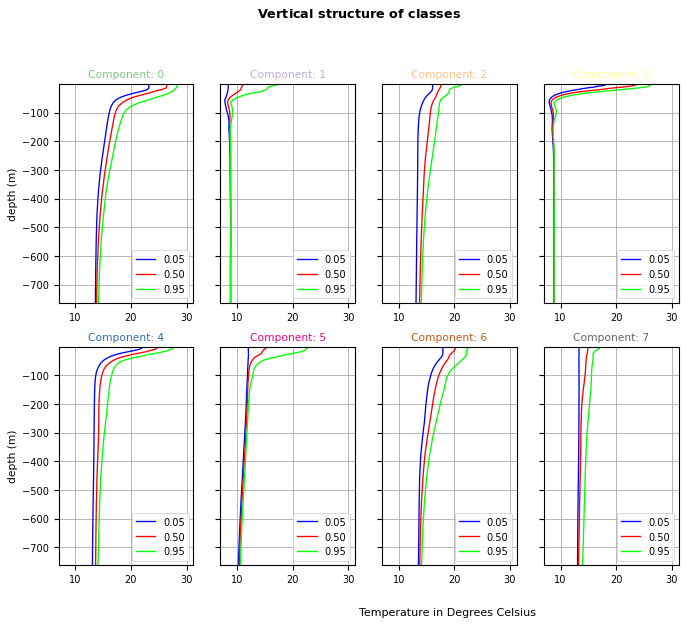

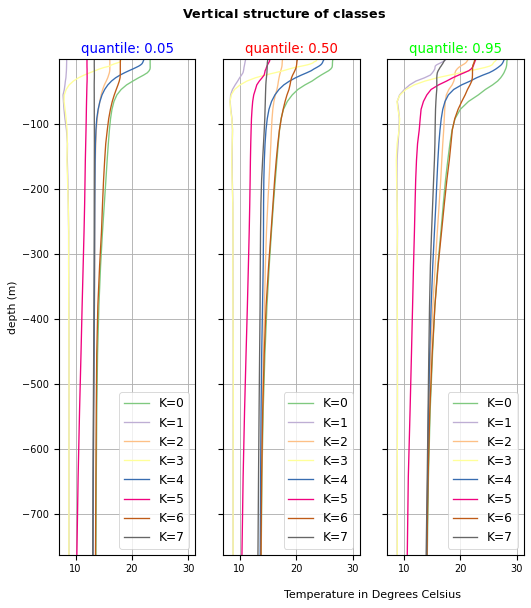

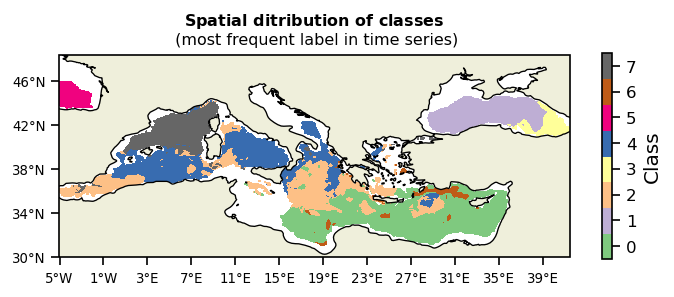

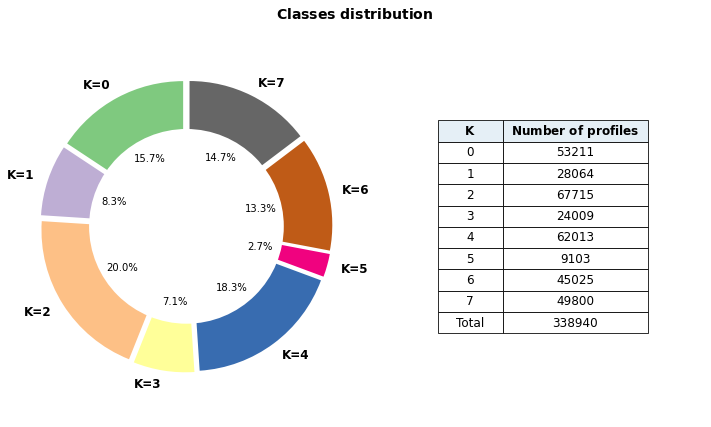

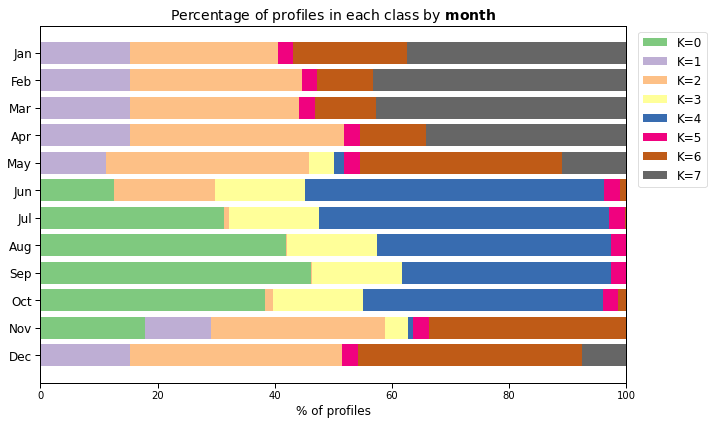

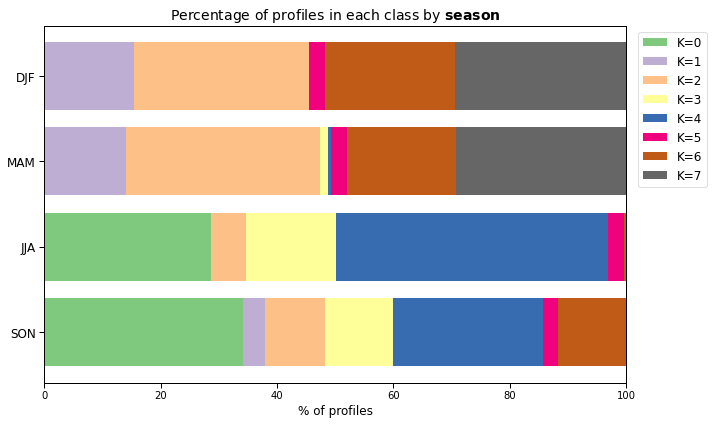

In [20]:
%%time
generate_plots(ds, var_name_ds, k, algorithm='dask')

In [16]:
# ds = x.load()
try:
    x_label = ds[var_name_ds].attrs['long_name'] + " in " + ds[var_name_ds].attrs['unit_long']
except KeyError:
    x_label = var_name_ds

# create a pyXpcm model to use the Plotter class
var_name_mdl = var_name_ds
z_dim = 'depth'
z = ds[z_dim]
pcm_features = {var_name_mdl: z}
m = pcm(K=k, features=pcm_features)
ds = ds.rename({'labels': 'PCM_LABELS'})
ds = ds.sortby('latitude').sortby('longitude')
P = Plotter(ds, m, coords_dict={'latitude': 'latitude', 'longitude': 'longitude', 'time': 'time', 'depth': 'depth'})

CPU times: user 676 ms, sys: 12 ms, total: 688 ms
Wall time: 1.23 s


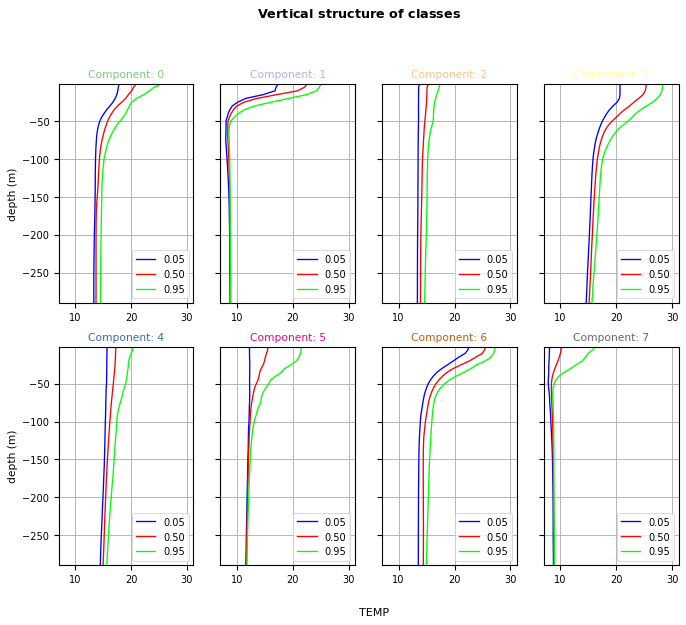

In [16]:
%%time
P.vertical_structure(q_variable=var_name_ds + '_Q', sharey=True, xlabel=x_label)

CPU times: user 92 ms, sys: 4 ms, total: 96 ms
Wall time: 93.8 ms


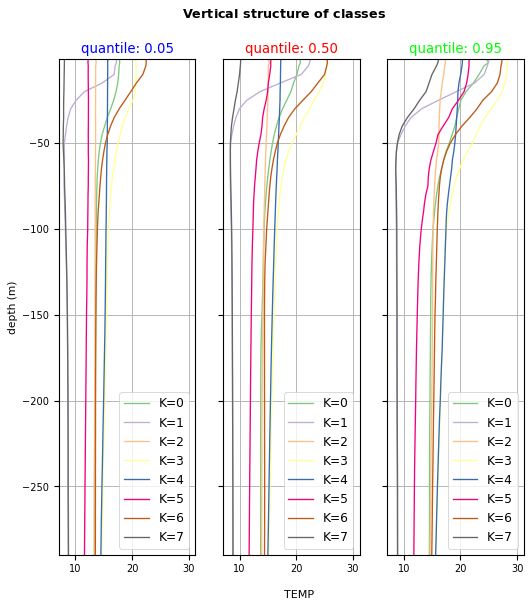

In [17]:
%%time
P.vertical_structure_comp(q_variable=var_name_ds + '_Q', plot_q='all', xlabel=x_label)

CPU times: user 652 ms, sys: 12 ms, total: 664 ms
Wall time: 920 ms


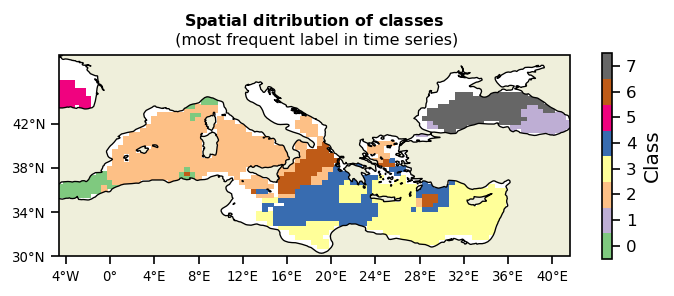

In [18]:
%%time
P.spatial_distribution(time_slice='most_freq_label')

CPU times: user 2.47 s, sys: 200 ms, total: 2.67 s
Wall time: 2.46 s


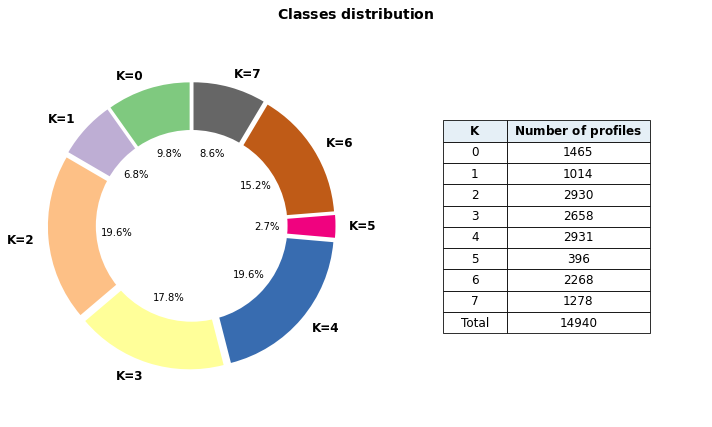

In [19]:
%%time
P.pie_classes()

In [18]:
ds

<xarray.Dataset>
Dimensions:              (depth: 41, feature: 41, feature_reduced: 15, k: 8, latitude: 39, longitude: 93, quantile: 3, time: 12)
Coordinates:
  * depth                (depth) float32 -1.0 -3.0 -5.0 ... -270.0 -280.0 -290.0
  * quantile             (quantile) float64 0.05 0.5 0.95
  * k                    (k) int64 0 1 2 3 4 5 6 7
  * longitude            (longitude) float64 -4.5 -4.0 -3.5 ... 40.5 41.0 41.5
  * latitude             (latitude) float64 30.89 31.31 31.74 ... 45.35 45.7
  * time                 (time) datetime64[ns] 2019-01-15 ... 2019-12-15
Dimensions without coordinates: feature, feature_reduced
Data variables:
    TEMP                 (depth, longitude, latitude, time) float32 dask.array<chunksize=(41, 93, 39, 12), meta=np.ndarray>
    TEMP_scaled          (feature, longitude, latitude, time) float32 dask.array<chunksize=(41, 93, 39, 12), meta=np.ndarray>
    TEMP_scaled_reduced  (feature_reduced, longitude, latitude, time) float32 dask.array<chunksize=(15, 93, 39, 12), meta=np.ndarray>
    PCM_LABELS           (longitude, latitude, time) float64 dask.array<chunksize=(2, 39, 12), meta=np.ndarray>
    TEMP_Q               (k, quantile, depth) float64 22.35 22.35 ... 15.8 15.71
Attributes: (12/20)
    Conventions:            CF-1.4
    title:                  Monthly analysis
    history:                20200803T112051L : Creation
    institution:            LPO/IFREMER
    project_name:           ISASLPO
    analysis_name:          CORA5.1_CH14_
    ...                     ...
    start_date:             2019-01-15
    stop_date:              2019-01-15
    creation_date:          20200803T112051L
    reference_date:         19500101T000000
    references:             Gaillard et al., JCLIM 2016, Doi:10.1175/JCLI-D-1...
    comment:                V7.0 T and S fields

In [8]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
